## Initial setup

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
!nvidia-smi

Thu Aug 20 11:45:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [ ]:
!wget https://github.com/ariG23498/G-SimCLR/releases/download/v1.0/X_new.npy

In [ ]:
train_data = np.load("X_new.npy")
train_data.shape

(1250, 224, 224, 3)

In [ ]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [ ]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [ ]:
# Image preprocessing utils
@tf.function
def scale_resize(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [ ]:
# Create TensorFlow dataset
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices(train_data)
train_ds = (
    train_ds
    .map(scale_resize, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(AUTO)
)

## Utilities

In [ ]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [ ]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

Don't forget to comment the `augmentation` import in the `helpers.py` script.

In [ ]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [ ]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [ ]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [ ]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

## Training

  0%|          | 1/200 [00:40<2:12:41, 40.01s/it]

epoch: 1 loss: 4.740


  6%|▌         | 11/200 [04:41<1:17:11, 24.51s/it]

epoch: 11 loss: 4.018


 10%|█         | 21/200 [08:41<1:11:36, 24.00s/it]

epoch: 21 loss: 3.483


 16%|█▌        | 31/200 [12:43<1:08:02, 24.16s/it]

epoch: 31 loss: 3.017


 20%|██        | 41/200 [16:43<1:03:44, 24.05s/it]

epoch: 41 loss: 2.629


 26%|██▌       | 51/200 [20:44<59:46, 24.07s/it]  

epoch: 51 loss: 2.342


 30%|███       | 61/200 [24:44<55:38, 24.02s/it]

epoch: 61 loss: 2.185


 36%|███▌      | 71/200 [28:45<51:45, 24.08s/it]

epoch: 71 loss: 2.026


 40%|████      | 81/200 [32:45<47:40, 24.04s/it]

epoch: 81 loss: 1.938


 46%|████▌     | 91/200 [36:46<43:46, 24.10s/it]

epoch: 91 loss: 1.865


 50%|█████     | 101/200 [40:45<39:35, 24.00s/it]

epoch: 101 loss: 1.789


 56%|█████▌    | 111/200 [44:45<35:36, 24.01s/it]

epoch: 111 loss: 1.735


 60%|██████    | 121/200 [48:46<31:39, 24.04s/it]

epoch: 121 loss: 1.684


 66%|██████▌   | 131/200 [52:46<27:41, 24.08s/it]

epoch: 131 loss: 1.641


 70%|███████   | 141/200 [56:47<23:39, 24.06s/it]

epoch: 141 loss: 1.606


 76%|███████▌  | 151/200 [1:00:47<19:39, 24.06s/it]

epoch: 151 loss: 1.570


 80%|████████  | 161/200 [1:04:48<15:36, 24.01s/it]

epoch: 161 loss: 1.546


 86%|████████▌ | 171/200 [1:08:48<11:38, 24.08s/it]

epoch: 171 loss: 1.530


 90%|█████████ | 181/200 [1:12:49<07:36, 24.05s/it]

epoch: 181 loss: 1.516


 96%|█████████▌| 191/200 [1:16:49<03:36, 24.07s/it]

epoch: 191 loss: 1.501


100%|██████████| 200/200 [1:20:26<00:00, 24.13s/it]


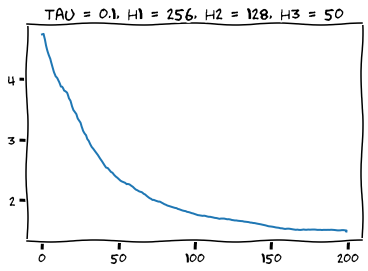

In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=200)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

## Store the weights to a safe place :)

In [ ]:
resnet_simclr.save_weights('resnet_simclr_modified_ae.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r resnet_simclr_modified_ae.h5 /content/drive/My\ Drive